In [1]:
import lightkurve
import numpy
import matplotlib as plt
from lightkurve import search_tesscut
import astropy.io.fits as pf
import matplotlib.pyplot as plt
import lightkurve as lk
import numpy as np
from astropy import units as u

from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord

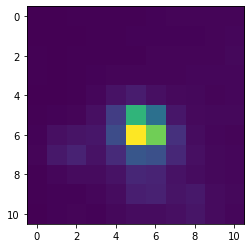

In [2]:
searchtic = 'TIC 55525572'  #349972099
sec = 8

search_result = lk.search_tesscut(searchtic, sector=sec)
tpf = search_result.download(cutout_size=11)

plt.imshow(tpf.flux[0])

/Library/Python/anaconda/envs/astroconda/lib/python3.7/site-packages/astroplan/plots/finder.py:94: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(projection=wcs)


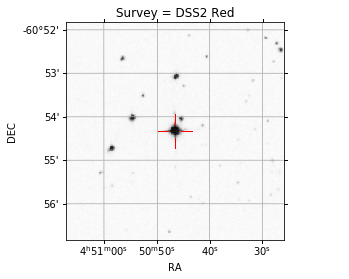

In [40]:
from astroplan.plots import plot_finder_image
from astroplan import FixedTarget

tic = 55525572
ra = 72.69401
dec = -60.905461


survey = 'DSS2 Red'
fig, ax = plt.subplots()
plt.axis("off")

target_coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
target = FixedTarget(coord=target_coord, name="Survey = {}".format(survey))

ax, hdu = plot_finder_image(target, survey = survey, reticle='True', reticle_style_kwargs = args, fov_radius=5*u.arcmin)


In [49]:
import os
import astropy
import numpy as np
import pandas as pd
import seaborn as sb

import requests
import lightkurve as lk
from os.path import exists
import astropy.io.fits as pf
import matplotlib.pyplot as plt
from astroplan import FixedTarget
from astropy.stats import BoxLeastSquares
from astroplan.plots import plot_finder_image
from astropy.stats import median_absolute_deviation

from glob import glob
from astropy.wcs import WCS
from astropy.io import fits
from astropy import units as u
from astroquery.mast import Catalogs
from sklearn.decomposition import PCA
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord
from matplotlib.patches import Rectangle
from lightkurve import TessTargetPixelFile

from tess_stars2px import tess_stars2px_function_entry
from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter
from matplotlib.widgets import Slider, Button, RadioButtons, TextBox, CheckButtons


In [50]:
from reproject.mosaicking import find_optimal_celestial_wcs

In [51]:
array = (tpf.flux.mean(axis=0))

where_are_NaNs = np.isnan(array)

array[where_are_NaNs] = 0

Header = (tpf.wcs)
tup = (array,Header)


In [52]:
def tpf_data(indir, sector, tic):

    
    dwload_link = []
    
    if sector == 'all':
        # locate the file string
        tpf_all = np.genfromtxt('{}/data/tesscurl_sector_all_tp.sh'.format(indir), dtype = str)
    
        for i in tpf_all:
            if str(tic) in str(i[6]):
                dwload_link.append(i[6])
        
    else:

        future_sectors = []
        # locate the file string
        for s in sector:
            try:
                tpf_sec = np.genfromtxt('{}/data/tesscurl_sector_{}_tp.sh'.format(indir, str(s)), dtype = str)
            except:
                future_sectors.append(s)
            for i in tpf_sec:
                try:
                    if str(tic) in str(i[6]):
                        dwload_link.append(i[6])
                except:
                    print("{} was not observed in Sector {}".format(tic, sec))

        if len(future_sectors) > 0:
            print ("In the future, this TIC {} will be observed in sector(s) {}".format(tic, future_sectors))

    if len(dwload_link) == 0:
        print ("This TIC was not observed in Sector(s):   {}   .Try again with different sectors.".format(sector))


    TESS_unbinned_t_l = []
    TESS_binned_t_l = []
    small_binned_t_l= []
    TESS_unbinned_l= []
    TESS_binned_l= []
    small_binned_l= []
    tpf_list = []
 
    dwload_link_tp = dwload_link
    
    for idx,file in enumerate(dwload_link_tp):

        tpf = TessTargetPixelFile(file) # dowload the Target Pixel File
        tpf_list.append(tpf)

        try:

            lc = tpf.to_lightcurve()
            median_image = np.nanmedian(tpf.flux, axis=0)
            smaller_mask = median_image > np.nanpercentile(median_image, 50)
            #smaller_mask2 = median_image > np.nanpercentile(median_image, 75)
            
            # TESS binned
            TESS_unbinned = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask).flatten(window_length=100001)
            TESS_unbinned = TESS_unbinned.remove_outliers(6)
            
            # TESS binned
            TESS_binned = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask).flatten(window_length=100001)
            TESS_binned = TESS_binned.remove_outliers(6).bin(7)
            
            # Use a custom aperture binned
            small_binned = tpf.to_lightcurve(aperture_mask=smaller_mask).flatten(window_length=100001)
            small_binned = small_binned.remove_outliers(6).bin(7)
        
            #small_binned2 = tpf.to_lightcurve(aperture_mask=smaller_mask2).flatten(window_length=100001)
            #small_binned2 = small_binned2.remove_outliers(6).bin(7)
        
            TESS_unbinned_t = TESS_unbinned.time
            TESS_binned_t = TESS_binned.time
            small_binned_t = small_binned.time
             
            # ----------
            TESS_unbinned_t_l.append(TESS_unbinned_t)
            TESS_binned_t_l.append(TESS_binned_t)
            small_binned_t_l.append(small_binned_t)
            
            TESS_unbinned_l.append(TESS_unbinned.flux)
            TESS_binned_l.append(TESS_binned.flux)
            small_binned_l.append(small_binned.flux)
        
        except:
            continue
        
        #small_binned_t2 = small_binned2.time
        #plt.scatter(small_binned_t2, small_binned2.flux, s = 10, color = 'green', label = 'Small Aperture binned')
    
    TESS_unbinned_t_l = [val for sublist in TESS_unbinned_t_l for val in sublist]
    TESS_binned_t_l   = [val for sublist in TESS_binned_t_l for val in sublist]
    small_binned_t_l = [val for sublist in small_binned_t_l for val in sublist]
    
    TESS_unbinned_l = [val for sublist in TESS_unbinned_l for val in sublist]
    TESS_binned_l = [val for sublist in TESS_binned_l for val in sublist]
    small_binned_l = [val for sublist in small_binned_l for val in sublist]
    

    return TESS_unbinned_t_l, TESS_binned_t_l, small_binned_t_l, TESS_unbinned_l, TESS_binned_l, small_binned_l, tpf_list


indir = '/Users/Nora/Documents/research/TESS/planethunters/code/LATTE/LATTE_output/'
sectors = [5]
tic = '55525572'

TESS_unbinned_t_l, TESS_binned_t_l, small_binned_t_l, TESS_unbinned_l, TESS_binned_l, small_binned_l, tpf_list = tpf_data(indir, sectors, tic)

/Library/Python/anaconda/envs/astroconda/lib/python3.7/site-packages/astroplan/plots/finder.py:94: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(projection=wcs)


(300, 300)


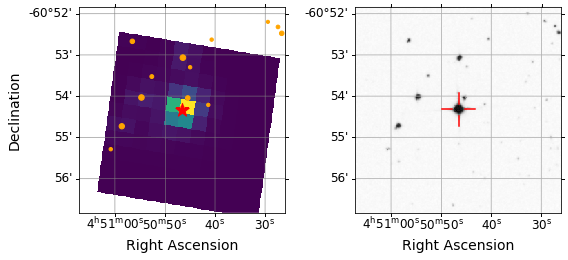

In [185]:
from reproject import reproject_interp, reproject_exact


peak_list = [1454.7] 
peak_sec = [5]

def plot_project_image(tic,indir,peak_list, peak_sec, tpf_list, save = False, show = False):
    
    '''
    Plot of the field of view round the target star showing nearby stars that are brighter than magnitude 17 as well as the SDSS cutout. 
    Both images are projected and oriented North for easy comparison. 
    
    Parameters
    ----------
    tic : str
        TIC (Tess Input Catalog) ID of the target
    indir : str
        path to where the files will be saved.
    peak_list   :  list
        list of the marked transit events
    peak_sec  :  list or str
        list of the sectors that are being analyse.
    save (default = False)
        if save = True, the figure is saved in the directory which has the name of the TIC ID
  
    Returns
    -------
        Plot of the averaged flux per pixel around the target (left) as well as the SDSS plot (right). The red star on the right plot indicated the location of the target.
        The orange circles show the location of nearby stars with magnitudes brighter than 17 mag where their relative sizes correspond to their relative 

    '''
    # Query nearby Gaia Stars  --------------------
    
    sector = str(peak_sec[0])

    starName = "TIC " + str(tic)
    radSearch = 5/60 #radius in degrees

    catalogData = Catalogs.query_object(starName, radius = radSearch, catalog = "TIC")
    
    # ra and dec of the target star
    ra = catalogData[0]['ra']
    dec = catalogData[0]['dec']

    # Create a list of nearby bright stars (tess magnitude less than 14) from the rest of the data for later.
    bright = catalogData['Tmag'] < 17

    start = [np.float64(peak_list[0]) - 0.2]
    end = [np.float64(peak_list[0]) + 0.2]

    # ---------------------------------------------
    # Get the data for the SDSS sky viewer --------
    
    survey = 'DSS2 Red'
    fig, ax = plt.subplots()
    plt.axis("off")
    
    target_coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
    target = FixedTarget(coord=target_coord, name="Survey = {}".format(survey))
    
    ax, hdu = plot_finder_image(target, survey = survey, reticle='True', reticle_style_kwargs = args, fov_radius=5*u.arcmin)
    plt.close('all')
    # --------------------------------------------

    for i, tpf in enumerate(tpf_list):

        # plt.subplot(row column number)
        if (start > np.nanmin(tpf.time) and start < np.nanmax(tpf.time)):
            
            
            fig= plt.figure(figsize=(7,5))

            sector =  tpf.header['SECTOR']
    
            # create a tupple of the array of the data and the wcs projection of the TESS cutout
            tup = (tpf.flux.mean(axis=0),tpf.wcs)
            
            # map the SDSS and TESS image onto each other - the output will be orented NORTH!
            wcs_out, shape_out = find_optimal_celestial_wcs(input_data =[tup, hdu])
            
            # plot the reprojected TESS image 
            ax1 = plt.subplot(1,2,1, projection=wcs_out)
            array, footprint = reproject_interp(tup, wcs_out, shape_out = shape_out, order = 'nearest-neighbor')
            
            print (shape_out)
            
            ax1.imshow(array, origin='lower')
            ax1.coords['ra'].set_axislabel('Right Ascension', fontsize = 14)
            ax1.coords['dec'].set_axislabel('Declination', fontsize = 14)
            ax1.grid(color = 'grey', alpha = 0.7)
            
            # plot the nearby GAIA stars on this image too...
            ra_stars, dec_stars = catalogData[bright]['ra'], catalogData[bright]['dec']
            s = np.maximum((19 - catalogData[bright]['Tmag'])*5, 0)  # the size corresponds to their brightness
            ax1.scatter(ra_stars, dec_stars, s=s, transform=ax1.get_transform('icrs'), color='orange', zorder=100)

            # plot the target star that we're looking at
            ax1.scatter(ra, dec, s= 200, transform=ax1.get_transform('icrs'), marker = '*', color='red', zorder=100)
            ax1.tick_params(labelsize=12)
            
            # plot the reprojected SDSS image
            ax2 = plt.subplot(1,2,2, projection=wcs_out, sharex=ax1, sharey=ax1)
            array, footprint = reproject_interp(tup, wcs_out,shape_out = shape_out)
            ax2.imshow(hdu.data, origin='lower', cmap = 'Greys')
            ax2.coords['ra'].set_axislabel('Right Ascension', fontsize = 14)
            #ax2.coords['dec'].set_axislabel('Declination')
            
            # Draw reticle ontop of the target star
            pixel_width = hdu.data.shape[0]
            inner, outer = 0.03, 0.08
            
            reticle_style_kwargs = {}
            reticle_style_kwargs.setdefault('linewidth', 1.5)
            reticle_style_kwargs.setdefault('color', 'red')
            
            ax2.axvline(x=0.5*pixel_width, ymin=0.5+inner, ymax=0.5+outer,
                       **reticle_style_kwargs)
            ax2.axvline(x=0.5*pixel_width, ymin=0.5-inner, ymax=0.5-outer,
                       **reticle_style_kwargs)
            ax2.axhline(y=0.5*pixel_width, xmin=0.5+inner, xmax=0.5+outer,
                       **reticle_style_kwargs)
            ax2.axhline(y=0.5*pixel_width, xmin=0.5-inner, xmax=0.5-outer,
                           **reticle_style_kwargs)
            ax2.grid()
            ax2.tick_params(labelsize=12)
            plt.tight_layout(w_pad= 7)
            
            if save == True:
                plt.savefig('{}/{}/{}_star_field.png'.format(indir, tic, tic), format='png')
    
            if show == True:
                plt.show()
            else:
                plt.close()
    return catalogData
    #return catalogData['Tmag'][0], catalogData['Teff'][0], catalogData['rad'][0], catalogData['mass'][0]


catalogData = plot_project_image(tic,indir,peak_list, peak_sec, tpf_list, save = False, show = True)

In [182]:
from astropy.table import Table
from pandas import DataFrame


catalogData2 = DataFrame(np.array(catalogData))

target_ra = float(catalogData2['ra'][0]) 
target_dec = float(catalogData2['dec'][0])

# Calculated the angular separation to the stars to find the nearest neighbours
def star_sep(row, ra, dec):
    
    ra2 = float(row['ra'])
    dec2 = float(row['dec'])

    c1 = SkyCoord(ra*u.degree, dec*u.degree)
    c2 = SkyCoord(ra2*u.degree, dec2*u.degree)
    sep = c1.separation(c2)
    
    return sep.arcminute

catalogData2['dist'] = catalogData2.apply(star_sep, args = (target_ra,target_dec), axis=1)

    

In [154]:
closest_tic = catalogData2.sort_values('dist')[0:6]

In [155]:
closest_tic

,ID,ra,dec,pmRA,pmDEC,Tmag,objType,typeSrc,version,HIP,...,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,dstArcSec,dist
0,55525572,72.694043,-60.905449,-3.732610,-2.78863,9.8467,STAR,tmgaia2,20190415,,...,0.849221,0.839596,72.694010,-60.905461,0.020724,0.023031,1,0,0.000000,0.000000
1,55525570,72.690420,-60.902255,NaN,NaN,18.4727,STAR,tmgaia2,20190415,,...,0.341588,0.369870,72.690420,-60.902255,0.341588,0.369870,1,0,13.132484,0.218875
2,55525568,72.689362,-60.900789,2.214360,10.95770,14.7052,STAR,tmgaia2,20190415,,...,2.597720,2.572194,72.689382,-60.900742,0.064957,0.069723,1,0,18.668465,0.311141
3,55525567,72.694763,-60.898899,NaN,NaN,17.1290,STAR,2mass,20190415,,...,179.167000,170.878000,72.694763,-60.898899,179.167000,170.878000,-999,0,23.613046,0.393551
4,55525571,72.672304,-60.903553,-0.425209,-15.67800,16.7297,STAR,tmgaia2,20190415,,...,3.755974,3.759527,72.672300,-60.903620,0.091468,0.104181,1,0,38.662985,0.644383
5,684811457,72.673168,-60.911051,-6.087150,2.61416,20.3022,STAR,gaia2,20190415,,...,50.673613,31.889476,72.673114,-60.911040,0.858806,0.840974,1,1,41.735337,0.695589


In [171]:
def rebin(arr,new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
        new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

def norm(a):
    '''
    function to normalise the data - used in download_data_tpf
    '''
    m = np.median(a)
    x = a-m
    s = np.std(x)
    x = x/s
    return x, m, s

def unnorm(x,m,s):
    '''
    function to un-normalise the data - used in download_data_tpf
    '''
    y = x * s
    a = y + m
    return a


def download_data_tpf(indir, peak_sec, peak_list, tic):
    '''
    Download the TPF LCs for the target star for all the indicated sectors. Not using Lightkurve
    
    Parameters
    ----------
    indir : str
        path to where the files will be saved.
    peak_sec  :  list or str
        list of the sectors that have a transit in them. If 'all', all the sectors in whic the target appears will be downloaded
    tic : str
        TIC (Tess Input Catalog) ID of the target
    peak_list  :  int
        list of all the marked transits

    Returns
    -------
    X1_list  :  list
        flux vs time for each pixel
    X4_list  :  list
        PCA corrected flux vs time for each pixel
    oot_list  :  list
        out of transit mask
    intr_list  :  list
        in transit mask
    bkg_list  :  list
        the flux that was used to normalise each pixel - i.e. what is used to make the background plot colour for each pixel.
    apmask_list  :  list
        aperture masks from the pipeline
    arrshape_list  :  list
        shape of the array
    t_list  :  list
        time arrays
    T0_list  :  list
        list of the peaks
    '''

    X1_list = []
    X4_list = []
    oot_list = []
    intr_list = []
    bkg_list = []
    apmask_list = []
    arrshape_list = []
    t_list = []
    T0_list = []
    tpf_filt_list = []
    tpf_list = []
    
    #print ("peak list {}".format(peak_sec))

    dwload_link_tp = []

    for sec in peak_sec: #the sector that this image is in

        tpf_all = np.genfromtxt('{}/data/tesscurl_sector_{}_tp.sh'.format(indir,sec), dtype = str)
        
        for i in tpf_all:
        
            if str(tic) in str(i[6]):
                dwload_link_tp.append(i[6])
    
    # download each file (i.e. each sector)

    for file in dwload_link_tp:

        tpf = pf.open(file)   # open the file
        
        

        for T0 in peak_list:
            
            
            X1 = tpf[1].data['FLUX']
            arrshape = X1.shape
            
            Q = tpf[1].data['QUALITY']
            t = tpf[1].data['TIME']
            
            aperture = tpf[2].data
            apmask = aperture >= np.nanmax(aperture)


            if (T0 > np.nanmin(t)) and (T0 < np.nanmax(t)):

                lkeep = (Q==0)
                bkg = X1[lkeep,:]
                bkg = bkg.mean(axis = 0)
                    
                bkg_list.append(bkg)
                apmask_list.append(apmask)
                arrshape_list.append(arrshape)

                s = X1.shape
                X1 = X1.reshape(s[0],s[1]*s[2])
                
                lkeep = np.isfinite(X1.sum(axis=1)) * (Q==0) * (X1.sum(axis=1)>0)
                X1 = X1[lkeep,:]
                
                X2 = np.zeros_like(X1)
                M = np.zeros(X1.shape[1])
                S = np.zeros(X1.shape[1])
                for n in range(X1.shape[1]):
                    a = X1[:,n]
                    x, m, s = norm(a)
                    X2[:,n]=x
                    M[n] = m
                    S[n] = s
                
                ncomp = 4
                pca = PCA(n_components=ncomp)
                trends = pca.fit_transform(X2)
                weights = pca.components_
                
                X3 = np.copy(X2)
                for n in range(X2.shape[1]):
                    for m in range(ncomp):
                        X3[:,n] -= trends[:,m] * weights[m,n]
                        

                X4 = np.zeros_like(X3)
                for n in range(X2.shape[1]):
                    x = X3[:,n]
                    a = unnorm(x, M[n], S[n])
                    X4[:,n] = a
                
                t=tpf[1].data['TIME'][lkeep]
                
                tpf_filt = X4.reshape(tpf[1].data['FLUX'][lkeep,:,:].shape)


                oot = (abs(T0-t) < 0.56) * (abs(T0-t) < 0.3) 
                intr = abs(T0-t) < 0.1
        
                X1_list.append(X1) # not corrected
                X4_list.append(X4) #  PDC corrected
                oot_list.append(oot)  # out of transit filter
                intr_list.append(intr)  # in transit filter
                t_list.append(t)
                T0_list.append(T0)
                tpf_filt_list.append(tpf_filt)
                tpf_list.append(tpf)
                
    return X1_list, X4_list, oot_list, intr_list, bkg_list, apmask_list, arrshape_list, t_list, T0_list, tpf_filt_list, tpf_list


In [157]:
X1_list, X4_list, oot_list, intr_list, bkg_list, apmask_list, arrshape_list, t_list, T0_list, tpf_filt_list, tpf_list = download_data_tpf(indir, peak_sec, peak_list, tic)

/Library/Python/anaconda/envs/astroconda/lib/python3.7/site-packages/ipykernel/__main__.py:117: RuntimeWarning: invalid value encountered in greater


In [284]:
def plot_in_out_TPF(tic, indir, X4_list, oot_list, t_list, intr_list, T0_list, tpf_filt_list, tpf_list, save = False, show = False):
    
    plt.figure(figsize=(15,3.5*len(T0_list)))

    count = 0

    for idx, X4 in enumerate(X4_list):
        
        oot = oot_list[idx]
        intr = intr_list[idx]
        T0 = T0_list[idx]
        t = t_list[idx]
        tpf_filt  =  tpf_filt_list[idx]
        tpf = tpf_list[idx]
        
        # create a tupple of the array of the data and the wcs projection of the TESS cutout
        tup = (tpf.flux.mean(axis=0),tpf.wcs)
        
        # mapthe output will be oriented NORTH!
        wcs_out, shape_out = find_optimal_celestial_wcs(input_data =[tup], resolution = 0.0002*u.deg)
        
        array, footprint = reproject_interp(tup, wcs_out, shape_out = shape_out,order = 'nearest-neighbor')
           
        intr = abs(T0-t) < 0.25
        oot = (abs(T0-t) < 0.5) * (abs(T0-t) < 0.3)
        img_intr = tpf_filt[intr,:,:].sum(axis=0)/float(intr.sum())  # array
        img_oot = tpf_filt[oot,:,:].sum(axis=0)/float(oot.sum())     # array
        img_diff = img_oot-img_intr                                  # array
        
        
        tup_intr = (img_intr, tpf.wcs)
        tup_oot  = (img_oot, tpf.wcs)
        tup_diff = (img_diff, tpf.wcs)
        
        img_intr, _ = reproject_interp(tup_intr, wcs_out, shape_out = shape_out,order = 'nearest-neighbor')
        img_oot, _ = reproject_interp(tup_oot, wcs_out, shape_out = shape_out,order = 'nearest-neighbor')
        img_diff, _ = reproject_interp(tup_diff, wcs_out, shape_out = shape_out,order = 'nearest-neighbor')
        
        count += 1
        plt.subplot(len(T0_list), 3, count,projection=wcs_out)
        plt.axis('off')
        plt.imshow(img_intr)
        plt.colorbar()
        plt.xlabel("RA", fontsize = 12)
        plt.ylabel("Dec", fontsize = 12)
        plt.title("t = {} days \n In Transit Flux (e-/candence)".format(T0), fontsize = 13)

        count += 1
        plt.subplot(len(T0_list), 3, count,projection=wcs_out)
        plt.axis('off')
        plt.imshow(img_oot)
        plt.colorbar()
        plt.xlabel("RA", fontsize = 12)
        plt.title("Out of Transit Flux (e-/candence)", fontsize = 13)

        count += 1
        plt.subplot(len(T0_list), 3, count,projection=wcs_out)
        plt.axis('off')
        plt.imshow(img_diff)
        plt.colorbar()
        plt.xlabel("RA", fontsize = 12)
        plt.title("Difference Flux (e-/candence)", fontsize = 13)

        
    plt.tight_layout(w_pad= -2)

    if save == True:
        plt.savefig('{}/{}/{}_flux_comparison.png'.format(indir, tic, tic), format='png')
    
    if show == True:
        plt.show()
    else:
        plt.close()


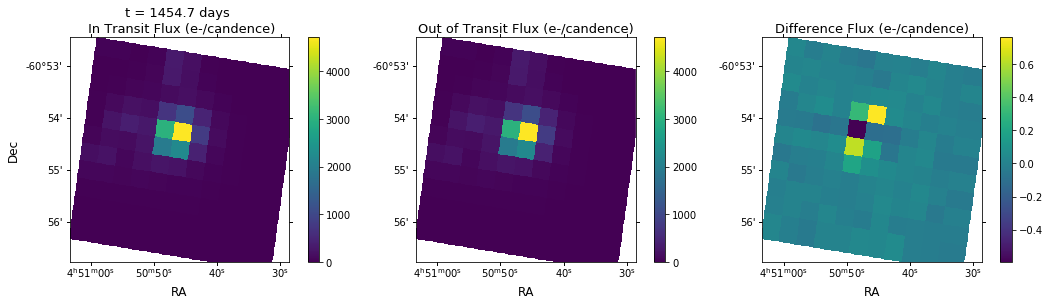

In [285]:
plot_in_out_TPF(tic, indir, X4_list, oot_list, t_list, intr_list, T0_list, tpf_filt_list, tpf_list, save = False, show = True)